In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from scanfields import ScanFields

In [3]:
class Field:
    def __init__(self, field, spin):
        if all(isinstance(x, float) for x in field):
            self.field = field + 1j*np.zeros(len(field))
        else:
            self.field = field
        self.spin = spin

class SignalFields:
    def __init__(self, *fields: Field):
        self.fields = sorted(fields, key=lambda field: field.spin)
        self.spins = np.array([field.spin for field in self.fields])

def couple_fields(scan_fields: ScanFields, signal_fields: SignalFields, spin_out: int):
    results = []
    for i in range(len(signal_fields.spins)):
        n = spin_out - signal_fields.spins[i]
        print(f"n-n': {n}, n: {signal_fields.spins[i]}")
        results.append(scan_fields.get_xlink(n) * signal_fields.fields[i].field)
    return np.array(results)

In [4]:
# Load single detector map
base_path = "../crosslinks_2407_3yr/boresight"
sf1 = ScanFields.load_det(base_path, "nside128_boresight.h5")
maps = hp.read_map("./cmb_0000_nside_128_seed_33.fits", field=(0,1,2)) * 1e6


In [5]:
g_a = 0.01
g_b = 0.0
delta_g = g_a - g_b
P = maps[1] + 1j*maps[2]

signal_field = SignalFields(
    Field(delta_g * maps[0] / 2, spin=0),
    Field((2.0+g_a+g_b) * P / 4, spin=2),
    Field((2.0+g_a+g_b) * P.conj() / 4, spin=-2),
)

"""
signal_field = SignalFields(
    Field(maps[0], spin=0),
    Field(0.5 * P, spin=2),
    Field(0.5 * P.conj(), spin=-2),
)
"""


'\nsignal_field = SignalFields(\n    Field(maps[0], spin=0),\n    Field(0.5 * P, spin=2),\n    Field(0.5 * P.conj(), spin=-2),\n)\n'

In [6]:
s0 = couple_fields(sf1, signal_field, 0).sum(0)
s2 = couple_fields(sf1, signal_field, 2).sum(0)
sm2 = couple_fields(sf1, signal_field, -2).sum(0)

n-n': 2, n: -2
n-n': 0, n: 0
n-n': -2, n: 2
n-n': 4, n: -2
n-n': 2, n: 0
n-n': 0, n: 2
n-n': 0, n: -2
n-n': -2, n: 0
n-n': -4, n: 2


In [30]:
b = np.array([s2/2, sm2/2])
A = sf1.get_covmat_2D()
x = np.empty_like(b)

for i in range(b.shape[1]):
    x[:,i] = np.linalg.solve(A[:,:,i], b[:,i])

residual = np.array([
    np.zeros_like(maps[0]), # dummy T
    maps[1]-x[0].real,      # Delta Q
    maps[2]-x[0].imag       # Delta U
    ])

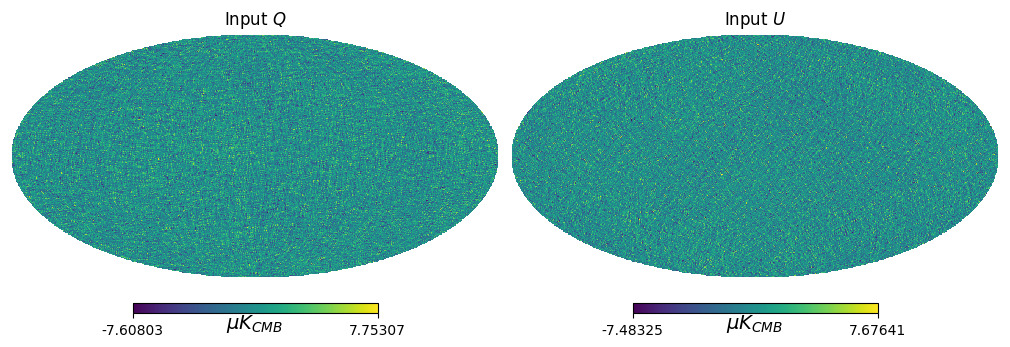

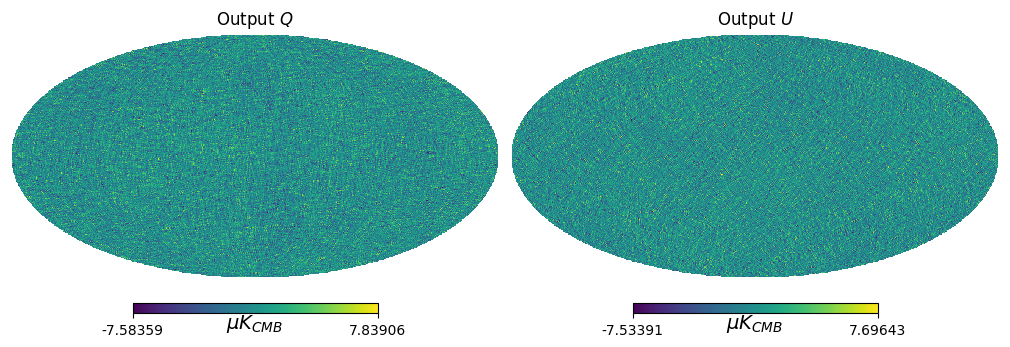

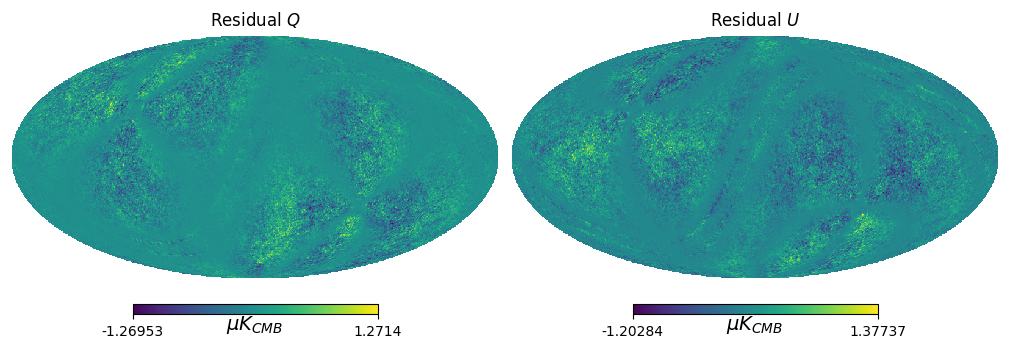

In [33]:
plt.figure(figsize=(10,5))
hp.mollview(maps[1], sub=(1,2,1), title="Input $Q$", unit="$\mu K_{CMB}$")
hp.mollview(maps[2], sub=(1,2,2), title="Input $U$", unit="$\mu K_{CMB}$")

plt.figure(figsize=(10,5))
hp.mollview(x[0].real, sub=(1,2,1), title="Output $Q$", unit="$\mu K_{CMB}$")
hp.mollview(x[0].imag, sub=(1,2,2), title="Output $U$", unit="$\mu K_{CMB}$")

plt.figure(figsize=(10,5))
hp.mollview(residual[1], sub=(1,2,1), title="Residual $Q$", unit="$\mu K_{CMB}$")
hp.mollview(residual[2], sub=(1,2,2), title="Residual $U$", unit="$\mu K_{CMB}$")

In [34]:
input_cl = hp.anafast(maps)
res_cl = hp.anafast(residual)

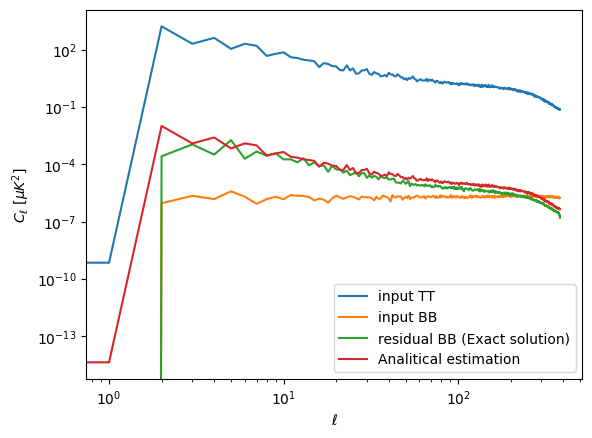

In [35]:
plt.plot(input_cl[0], label="input TT")
plt.plot(input_cl[2], label="input BB")
plt.plot(res_cl[2], label="residual BB (Exact solution)")

plt.plot(input_cl[0] * np.abs(sf1.get_xlink(2)).mean()**2 * delta_g**2, label="Analitical estimation")
plt.xlabel("$\ell$")
plt.ylabel("$C_\ell ~ [\mu K^2]$")
plt.xscale("log")
plt.yscale("log")
plt.legend()

In [39]:
b = np.array([s0, s2/2, sm2/2])
A = sf1.get_covmat_3D()
x = np.empty_like(b)

for i in range(b.shape[1]):
    x[:,i] = np.linalg.solve(A[:,:,i], b[:,i])

residual = np.array([
    maps[0]-x[0].real, # Delta T
    maps[1]-x[1].real, # Delta Q
    maps[2]-x[1].imag  # Delta U
    ])

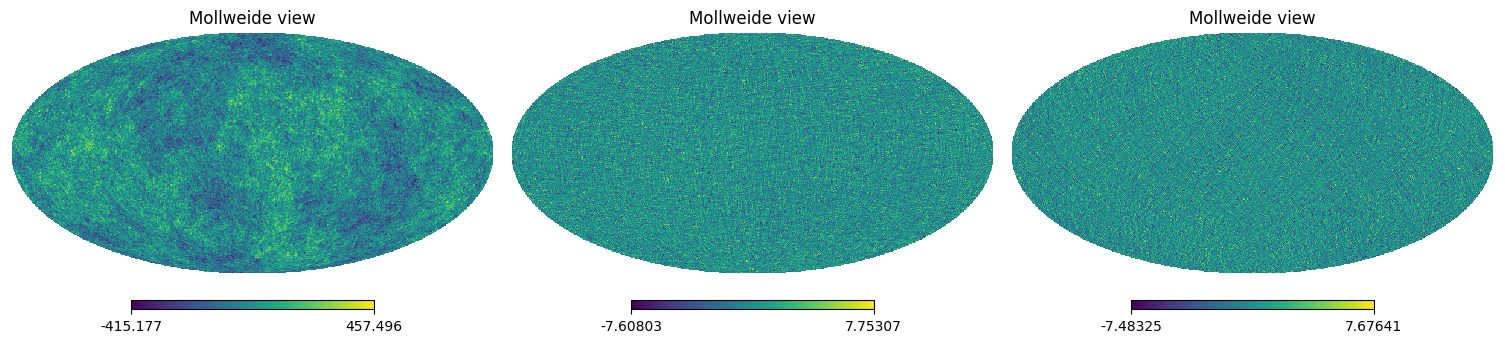

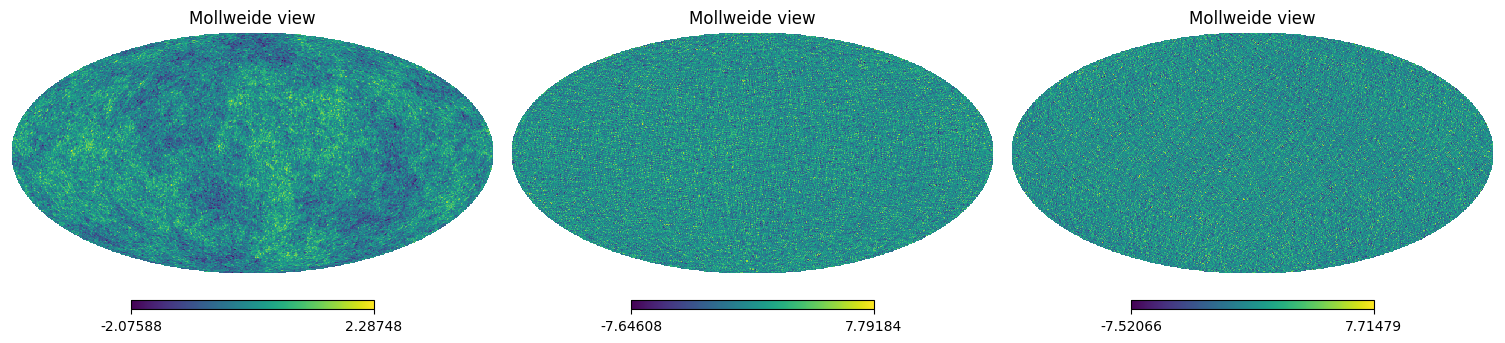

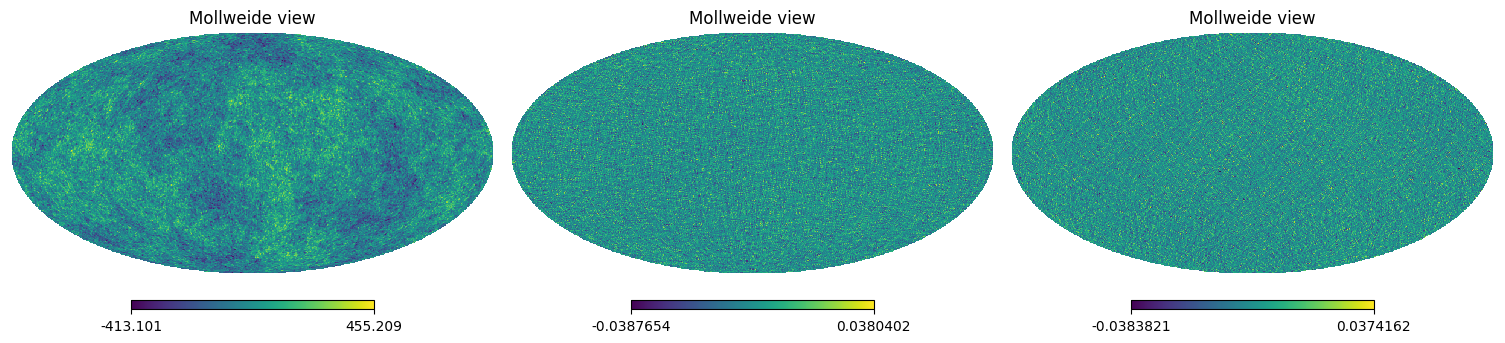

In [40]:

plt.figure(figsize=(15,5))
hp.mollview(maps[0], sub=(1,3,1))
hp.mollview(maps[1], sub=(1,3,2))
hp.mollview(maps[2], sub=(1,3,3))

plt.figure(figsize=(15,5))
hp.mollview(x[0].real, sub=(1,3,1))
hp.mollview(x[1].real, sub=(1,3,2))
hp.mollview(x[1].imag, sub=(1,3,3))

plt.figure(figsize=(15,5))
hp.mollview(residual[0], sub=(1,3,1))
hp.mollview(residual[1], sub=(1,3,2))
hp.mollview(residual[2], sub=(1,3,3))

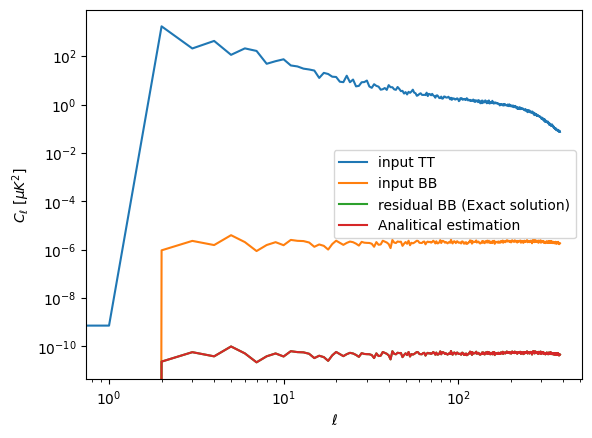

In [51]:
res_cl = hp.anafast(residual)

plt.plot(input_cl[0], label="input TT")
plt.plot(input_cl[2], label="input BB")
plt.plot(res_cl[2], label="residual BB (Exact solution)")

plt.plot(input_cl[2] * (delta_g/2)**2, label="Analitical estimation")
plt.xlabel("$\ell$")
plt.ylabel("$C_\ell ~ [\mu K^2]$")
plt.xscale("log")
plt.yscale("log")
plt.legend()